<a href="https://colab.research.google.com/github/LikaOkudzhava/BrainyScan/blob/InceptionV3/Alzheimer_model_inceptionV3_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [3]:
import os

import zipfile

from google.colab import drive

gdrive = '/content/drive'

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'smallpreprocessed'

archive_path = os.path.join(gdisk, filename)

with zipfile.ZipFile('/content/drive/MyDrive/AI/smallpreprocessed.zip', 'r') as zip_ref:

 zip_ref.extractall(f'{filename}')

In [4]:
dataset_dir = '/content/smallpreprocessed/data/SmallPreprocessed'
image_height = 224
image_width = 224
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'val'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

for ds in [train_ds, test_ds, val_ds]:
    ds.cache()
    ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 12000 files belonging to 4 classes.
Found 2000 files belonging to 4 classes.
Found 2000 files belonging to 4 classes.


In [5]:
from tensorflow import keras
import tensorflow as tf

# Set image dimensions for InceptionV3
image_height = 224
image_width = 224

# Define the model
model = keras.models.Sequential()

# Add InceptionV3 base model
model.add(
    tf.keras.applications.InceptionV3(
        input_shape=(image_height, image_width, 3),
        include_top=False,
        pooling='avg',
        weights='imagenet'
    )
)

# Add custom classifier layers
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))  # 4 classes

# Freeze base InceptionV3 layers
model.layers[0].trainable = False

# Build the model
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()




87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,121,892 (107.28 MB)

 Trainable params: 6,308,868 (24.07 MB)

 Non-trainable params: 21,813,024 (83.21 MB)

In [6]:
# Unfreeze the last 3 layers of InceptionV3 base model
base_model = model.layers[0]  # This is your InceptionV3 model

# Set all layers to non-trainable first
for layer in base_model.layers:
    layer.trainable = False

# Then unfreeze the last 3 layers
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Checkpoint - save only the best model
checkpoint_cb = ModelCheckpoint(
    "model_InceptionV3.keras",  # Updated filename
    save_best_only=True
)

# Early Stopping - stop if no improvement for 10 epochs
early_stopping_cb = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
EPOCHS = 25

In [9]:

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb]
)



Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - accuracy: 0.4445 - loss: 1.3620 - val_accuracy: 0.6330 - val_loss: 0.9346
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.6166 - loss: 0.9150 - val_accuracy: 0.6885 - val_loss: 0.7995
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.6867 - loss: 0.7769 - val_accuracy: 0.7125 - val_loss: 0.7375
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.7268 - loss: 0.6822 - val_accuracy: 0.7385 - val_loss: 0.6786
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.7631 - loss: 0.6084 - val_accuracy: 0.7415 - val_loss: 0.6497
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.7888 - loss: 0.5598 - val_accuracy: 0.7565 - val_loss: 0.6179
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.8074 - loss: 0.5025 - val_accuracy: 0.7735 - val_loss: 0.5878
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.8214 - loss: 0.4769 - 

In [10]:
model.save('/content/model_InceptionV3.keras')
model.export('/content/models/inceptionV3_model')

Saved artifact at '/content/models/inceptionV3_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_312')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133522224669776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224669584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224670352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224672272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224673040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224669392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224672848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224673616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224672656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133522224674192: TensorSpec(shape=(), dtype=tf.resource, name=N

In [4]:
score, acc= model.evaluate(test_ds)
print('Val Loss =', score)
print('Val Accuracy =', acc)

NameError: name 'model' is not defined

In [38]:
# Unfreeze the last 2 layers of InceptionV3 base model
base_model = model.layers[0]  # This is your InceptionV3 model

# Set all layers to non-trainable first
for layer in base_model.layers:
    layer.trainable = False

# Then unfreeze the last 3 layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Checkpoint - save only the best model
checkpoint_cb = ModelCheckpoint(
    "model_InceptionV3.keras",  # Updated filename
    save_best_only=True
)

# Early Stopping - stop if no improvement for 10 epochs
early_stopping_cb = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.9488 - loss: 0.1682 - val_accuracy: 0.8455 - val_loss: 0.4504
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.9526 - loss: 0.1565 - val_accuracy: 0.8485 - val_loss: 0.4669
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.9527 - loss: 0.1555 - val_accuracy: 0.8525 - val_loss: 0.4345
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9552 - loss: 0.1499 - val_accuracy: 0.8475 - val_loss: 0.4476
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.9562 - loss: 0.1433 - val_accuracy: 0.8500 - val_loss: 0.4529
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9582 - loss: 0.1381 - val_accuracy: 0.8525 - val_loss: 0.4384
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.9578 - loss: 0.1364 - val_accuracy: 0.8520 - val_loss: 0.4610
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.9607 - loss: 0.1264 - 

In [2]:
hist_=pd.DataFrame(history.history)

NameError: name 'pd' is not defined

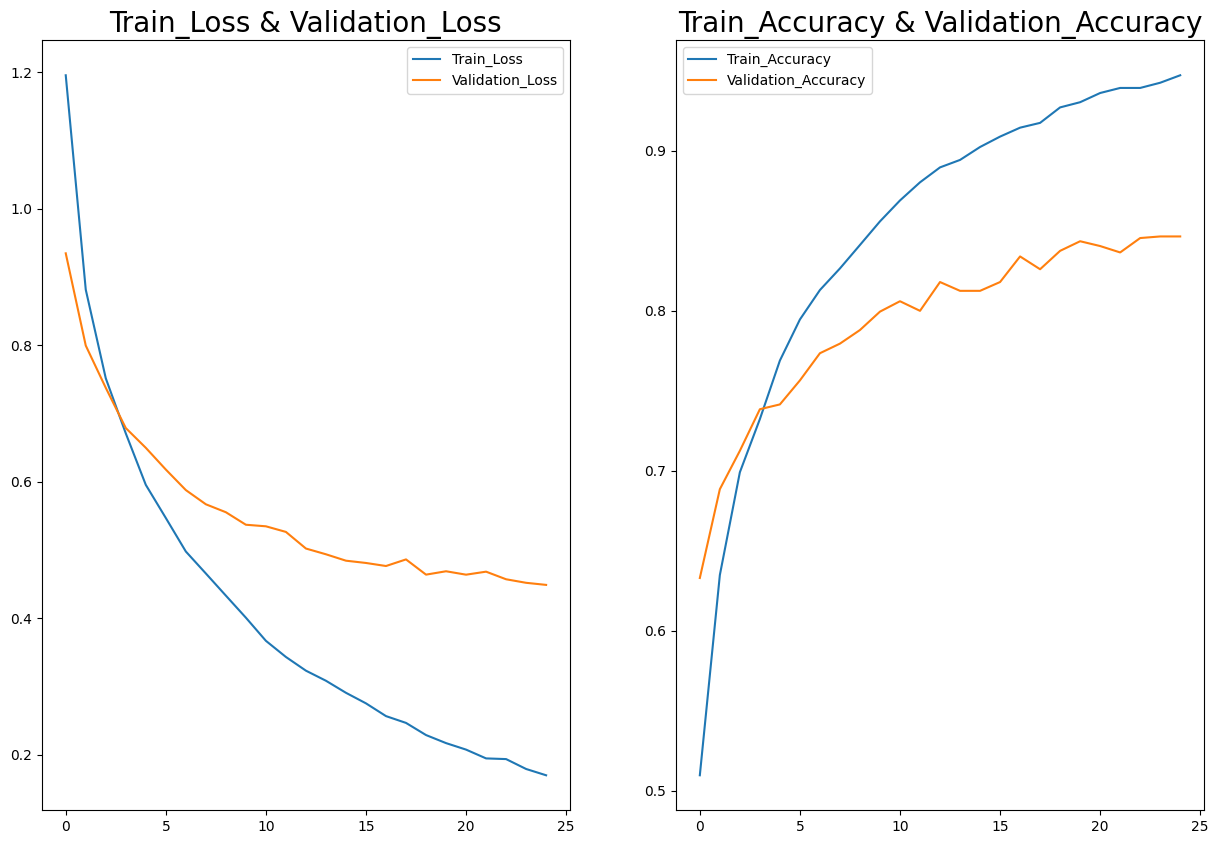

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [32]:
import numpy as np
import pandas as pd

# Convert test labels (one-hot) to class indices
y_test_labels = []
for batch in test_ds:
    images, labels = batch
    y_test_labels.append(labels.numpy())

y_test = np.concatenate(y_test_labels, axis=0)
y_test = np.argmax(y_test, axis=1)  # Convert one-hot to class index

# Predict using model
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)  # Class index

# Create a DataFrame with Actual vs Prediction
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


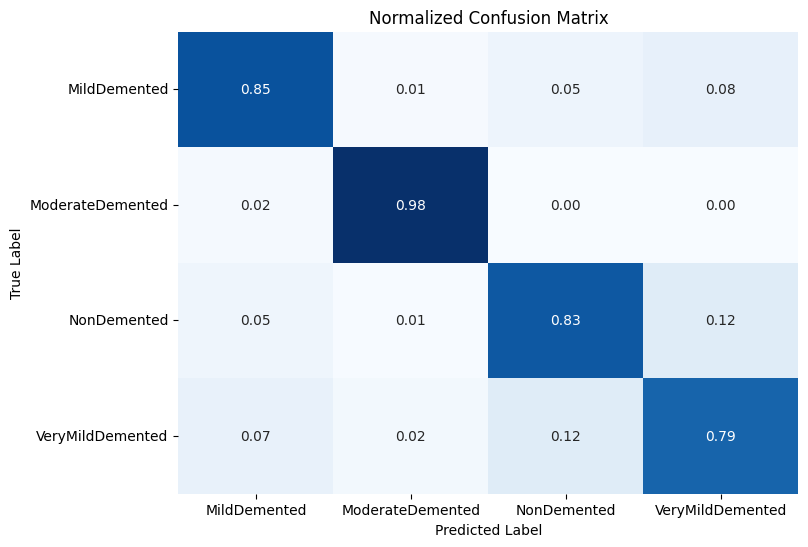

array([[427,   6,  25,  42],
       [  8, 491,   0,   1],
       [ 23,   3, 416,  58],
       [ 37,  12,  58, 393]])

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure your predicted and true labels are available
# y_test and y_pred should be 1D arrays of class indices

# Define class labels (update to match your actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Compute the confusion matrix
CM = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(CM_percent,
            fmt='.2f',
            annot=True,
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Optionally print the raw CM
CM


In [37]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_names)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                    precision    recall  f1-score   support

    MildDemented       0.86      0.85      0.86       500
ModerateDemented       0.96      0.98      0.97       500
     NonDemented       0.83      0.83      0.83       500
VeryMildDemented       0.80      0.79      0.79       500

        accuracy                           0.86      2000
       macro avg       0.86      0.86      0.86      2000
    weighted avg       0.86      0.86      0.86      2000

